In [2]:
# !pip install tensorflow
# !pip install keras

In [2]:
import gc
# import os
import keras
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

from keras.models import Model, Sequential, load_model
from keras.layers import (Input, 
                          Conv3D, 
                          MaxPooling3D, 
                          UpSampling3D, 
                          Concatenate, 
                          Flatten, 
                          Dense, 
                          GlobalAveragePooling3D, 
                          Dropout)

from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from multiprocessing import Pool, cpu_count

import src.zeldovich as Z

%matplotlib inline

2023-10-02 17:17:52.757369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async' # for gpu setting, not fully utilised in this code.

# Configure TensorFlow
config = tf.compat.v1.ConfigProto()
config.inter_op_parallelism_threads = 16  # number of cores put into use

# configuration at session creation
sess = tf.compat.v1.Session(config=config)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # not finding the GPU

Num GPUs Available:  0


In [5]:
## Random seed for producing the same results
np.random.seed(987)
tf.random.set_seed(987)

In [6]:
# Set the parameters
Lbox = 256.0  # Size of the simulation box
Ngrid = 32  # Grid size
pkfile = 'colossus_generated_data/pk_indra7313.txt'  # power spectrum

# Load power spectrum from txt file
pkinit = np.loadtxt(pkfile)

# decided to at least try 5000
num_simulations = 5000

In [7]:
# Run several simulations and store initial states and final states

def simulation(_):
    ic = np.random.normal(0., 1., (Ngrid, Ngrid, Ngrid))
    final_density, initial_conditions = Z.run_wn(0., ic, pkinit, boxsize=Lbox, ngrid=Ngrid)
    return (initial_conditions, final_density)

with Pool(cpu_count()) as p:
    data = list(tqdm(p.imap(simulation, range(num_simulations), chunksize=1), total=num_simulations))

100%|██████████| 5000/5000 [00:15<00:00, 332.91it/s]


In [8]:
# Convert the list into numpy array for easy data handling
data = np.array(data)

# Split the data
initial_state = data[:, 0]
final_state = data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

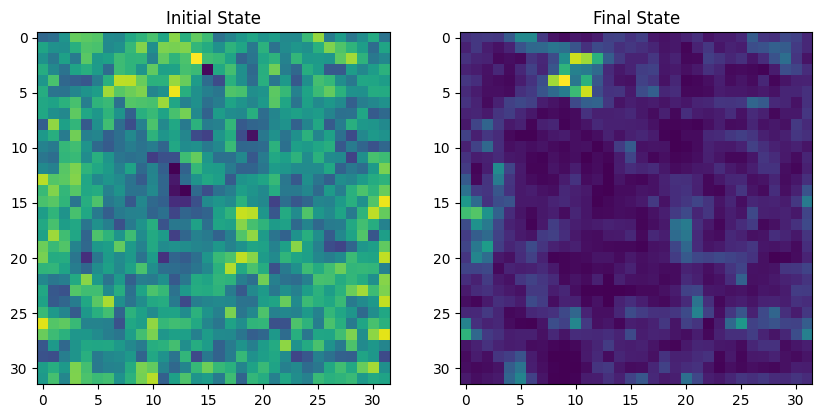

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# initial state and final state
axes[0].imshow(initial_conditions[0], cmap='viridis')
axes[0].set_title("Initial State")

axes[1].imshow(final_density[0], cmap='viridis')  
axes[1].set_title("Final State")

plt.show()

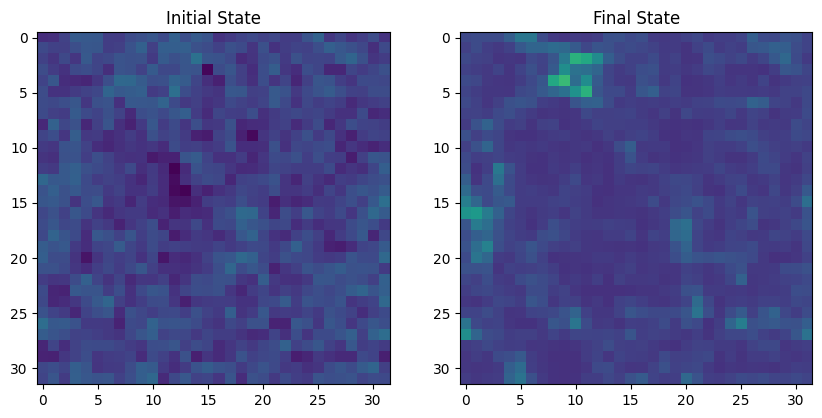

In [32]:
# Calculate vmin and vmax
vmin = min(initial_conditions.min(), final_density.min())
vmax = max(initial_conditions.max(), final_density.max())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot initial state
axes[0].imshow(initial_conditions[0], cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title("Initial State")

# Plot final state
axes[1].imshow(final_density[0], cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title("Final State")

plt.show()

> _the result on this data-point is shown at the end....._

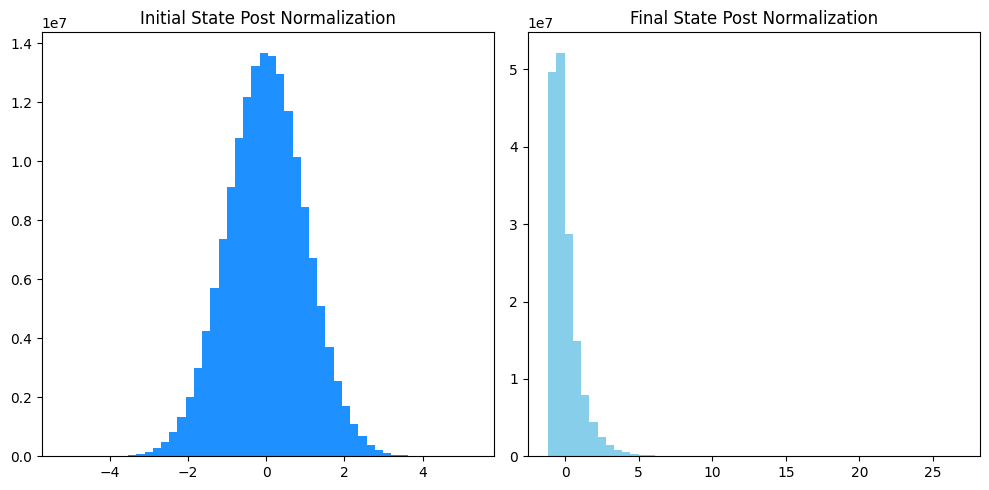

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms
axs[0].hist(initial_state.flatten(), bins=50, color='dodgerblue')
axs[0].set_title('Initial State Post Normalization')
axs[1].hist(final_state.flatten(), bins=50, color='skyblue')
axs[1].set_title('Final State Post Normalization')

plt.tight_layout()
plt.show()

In [11]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.2, random_state=987)

# further splitting it in training and testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=987)

In [12]:
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the following dimensions: 
# (batch_size, height, width, depth, num_channels)
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train = np.reshape(y_train, (*y_train.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

In [13]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape

((3600, 32, 32, 32, 1),
 (400, 32, 32, 32, 1),
 (3600, 32, 32, 32, 1),
 (400, 32, 32, 32, 1),
 (1000, 32, 32, 32, 1),
 (1000, 32, 32, 32, 1))

In [14]:
def create_simplified_conv3d_model(input_shape):
    model = Sequential()

    # Add Convolutional layers
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))  # Reduced filter size
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))  # Reduced filter size
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Global Average Pooling layer
    model.add(GlobalAveragePooling3D())

    # Dense layers
    model.add(Dense(256, activation='relu'))  # Reduced size

    # Output layer
    model.add(Dense(np.prod(input_shape), activation='linear'))  # Match the size of the flattened target labels

    return model

In [15]:
# Create the model
conv3d_model = create_simplified_conv3d_model((Ngrid, Ngrid, Ngrid, 1))

2023-10-02 17:18:23.517122: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
# Compile the model
conv3d_model.compile(optimizer='adam', 
             loss='mean_squared_error',
             run_eagerly=True)

In [17]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model_checkpoint = ModelCheckpoint('conv3d_1_simple_model.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [18]:
# Flatten the target labels
y_train_flattened = y_train.reshape(y_train.shape[0], -1)
y_val_flattened = y_val.reshape(y_val.shape[0], -1)
y_test_flattened = y_test.reshape(y_test.shape[0], -1)

In [ ]:
# Train the model
history = conv3d_model.fit(x=X_train,
                    y=y_train_flattened,  # flattened labels
                    validation_data=(X_val, y_val_flattened),  # flattened labels
                    batch_size=32,
                    epochs=50,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.9942
Epoch 1: loss improved from inf to 0.99420, saving model to conv3d_1_simple_model.hdf5
113/113 [==============================] - 192s 2s/step - loss: 0.9942 - val_loss: 0.9923 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.9933
Epoch 2: loss improved from 0.99420 to 0.99332, saving model to conv3d_1_simple_model.hdf5
113/113 [==============================] - 191s 2s/step - loss: 0.9933 - val_loss: 0.9919 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 0.9932
Epoch 3: loss improved from 0.99332 to 0.99317, saving model to conv3d_1_simple_model.hdf5
113/113 [==============================] - 191s 2s/step - loss: 0.9932 - val_loss: 0.9921 - lr: 0.0010
Epoch 4/50
113/113 [==============================] - ETA: 0s - loss: 0.9931
Epoch 4: loss improved from 0.99317 to 0.99310, saving model to conv3d_1_simple_model.hdf5
113/113 [==============

In [22]:
# Train the model
# history = conv3d_model.fit(x=X_train,
#                     y=y_train_flattened,  # flattened labels
#                     validation_data=(X_val, y_val_flattened),  # flattened labels
#                     batch_size=64,
#                     epochs=50,
#                     callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 0.9944
Epoch 1: loss improved from inf to 0.99443, saving model to conv3d_1_simple_model.hdf5
57/57 [==============================] - 188s 3s/step - loss: 0.9944 - val_loss: 0.9924 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 0.9931
Epoch 2: loss improved from 0.99443 to 0.99313, saving model to conv3d_1_simple_model.hdf5
57/57 [==============================] - 186s 3s/step - loss: 0.9931 - val_loss: 0.9920 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - ETA: 0s - loss: 0.9930
Epoch 3: loss improved from 0.99313 to 0.99304, saving model to conv3d_1_simple_model.hdf5
57/57 [==============================] - 186s 3s/step - loss: 0.9930 - val_loss: 0.9923 - lr: 0.0010
Epoch 4/50
57/57 [==============================] - ETA: 0s - loss: 0.9930
Epoch 4: loss improved from 0.99304 to 0.99302, saving model to conv3d_1_simple_model.hdf5
57/57 [==============================

> Tried the same model with large batch-size but the model was unable to understand the data-nuances.

In [20]:
gc.collect() # freeing up memory

2059

In [21]:
# Load the model from last checkpoint if needed 
# conv3d_model = load_model('conv3d_1_simple_model.hdf5')

In [22]:
# model evaluation in batches to avoid OOM error
eval_results = conv3d_model.evaluate(x=X_test, y=y_test_flattened, batch_size=16)  # Using a small batch size
print(f"Evaluation Results:{eval_results}")

63/63 [==============================] - 1s 16ms/step - loss: 0.1510
Evaluation Results:0.15098655223846436


In [23]:
# model prediction
predictions = conv3d_model.predict(X_test)
predictions.shape

32/32 [==============================] - 1s 19ms/step


(1000, 32768)

In [24]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

(-5.222972054504006, 20.655647)

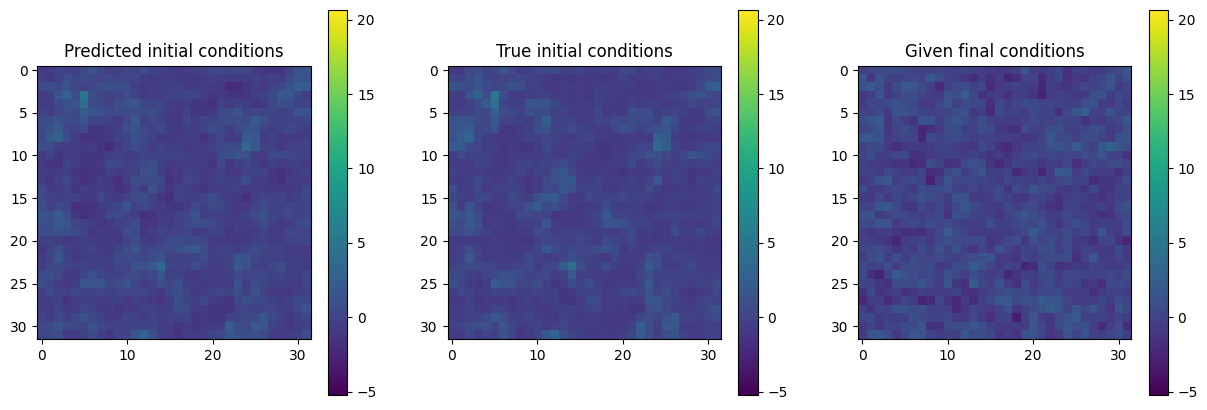

In [25]:
test_index = 0

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot predicted initial conditions
im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[:,:,Ngrid//2], vmin=vmin, vmax=vmax)
axs[0].set_title('Predicted initial conditions')
fig.colorbar(im, ax=axs[0])

# Plot true final conditions
im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[:,:,Ngrid//2], vmin=vmin, vmax=vmax)
axs[1].set_title('True initial conditions')
fig.colorbar(im, ax=axs[1])

# Plot initial conditions 
im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[:,:,Ngrid//2], vmin=vmin, vmax=vmax)
axs[2].set_title('Given final conditions')
fig.colorbar(im, ax=axs[2])

plt.show()

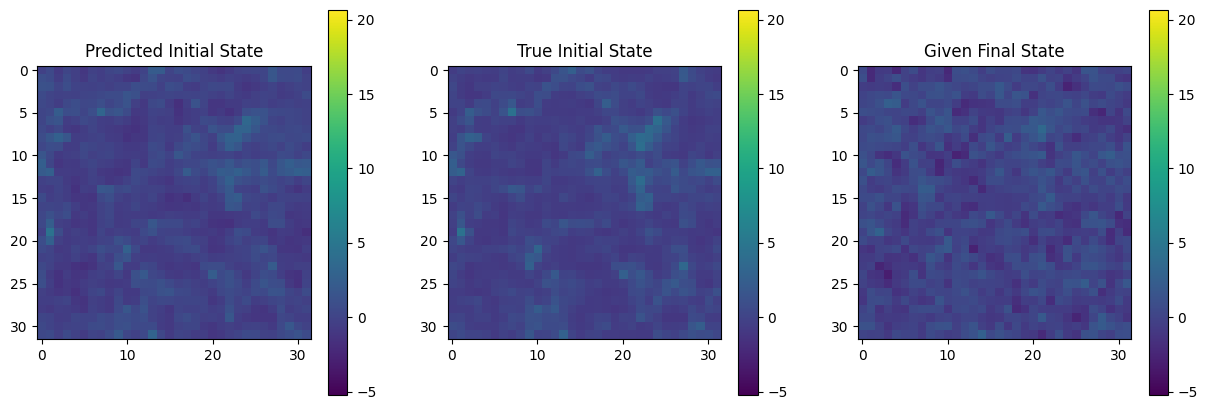

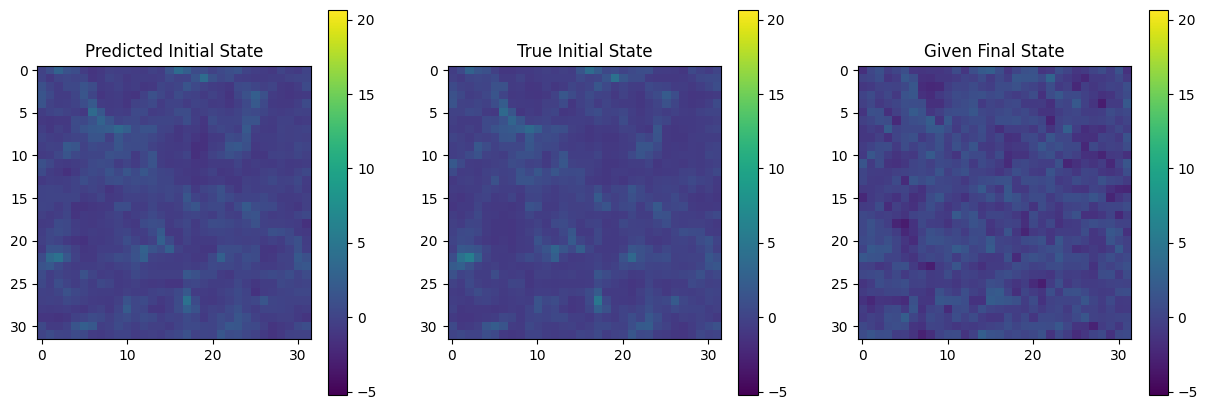

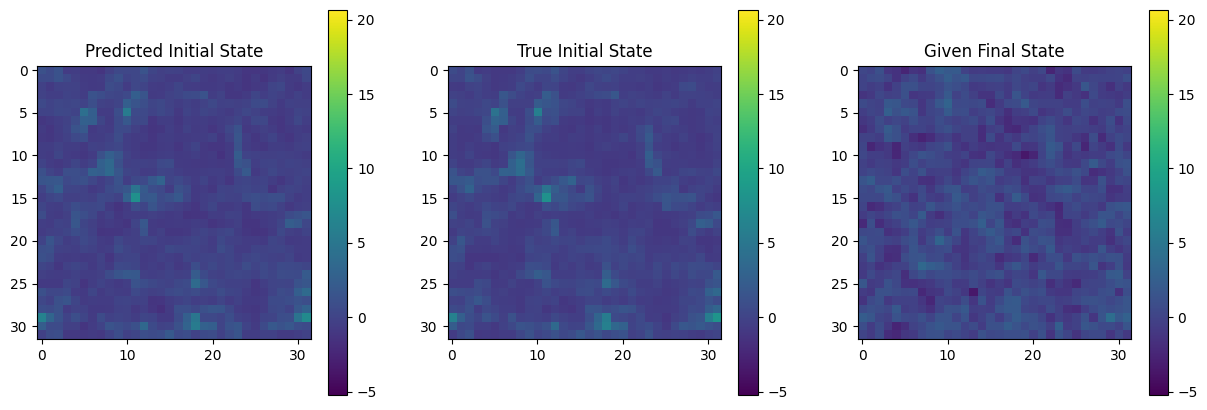

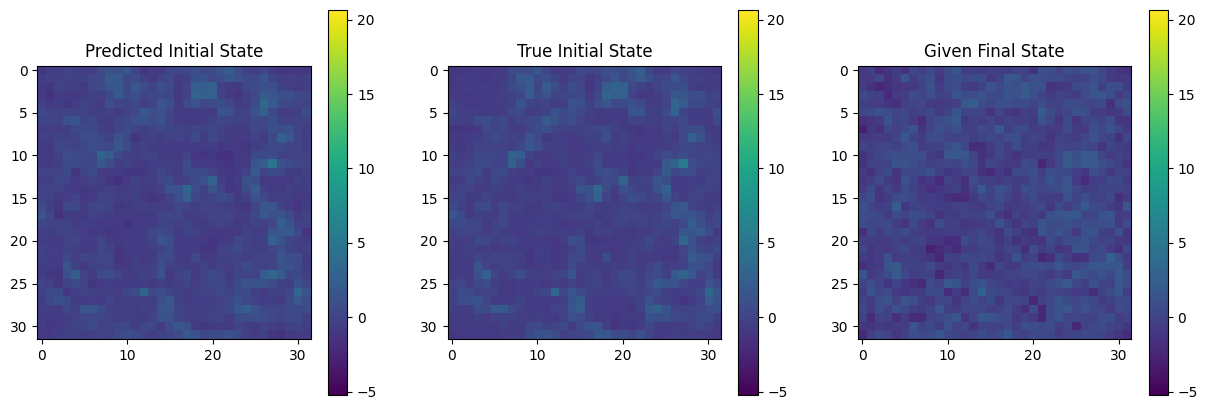

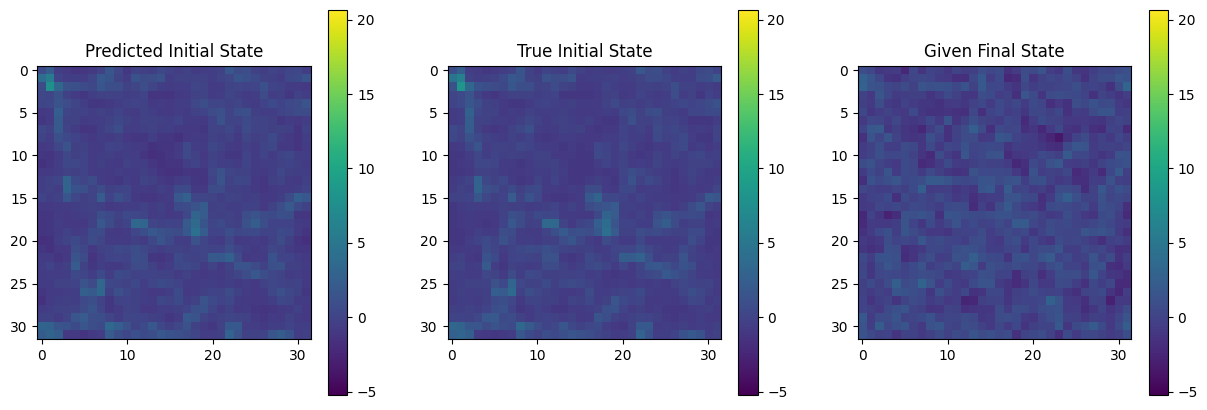

In [26]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # Plot true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # Plot given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [27]:
# calculating the error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.1509865593762348
Mean Absolute Error (MAE): 0.28827607663198107


In [28]:
y_test.shape, predictions.shape

((1000, 32, 32, 32, 1), (1000, 32768))

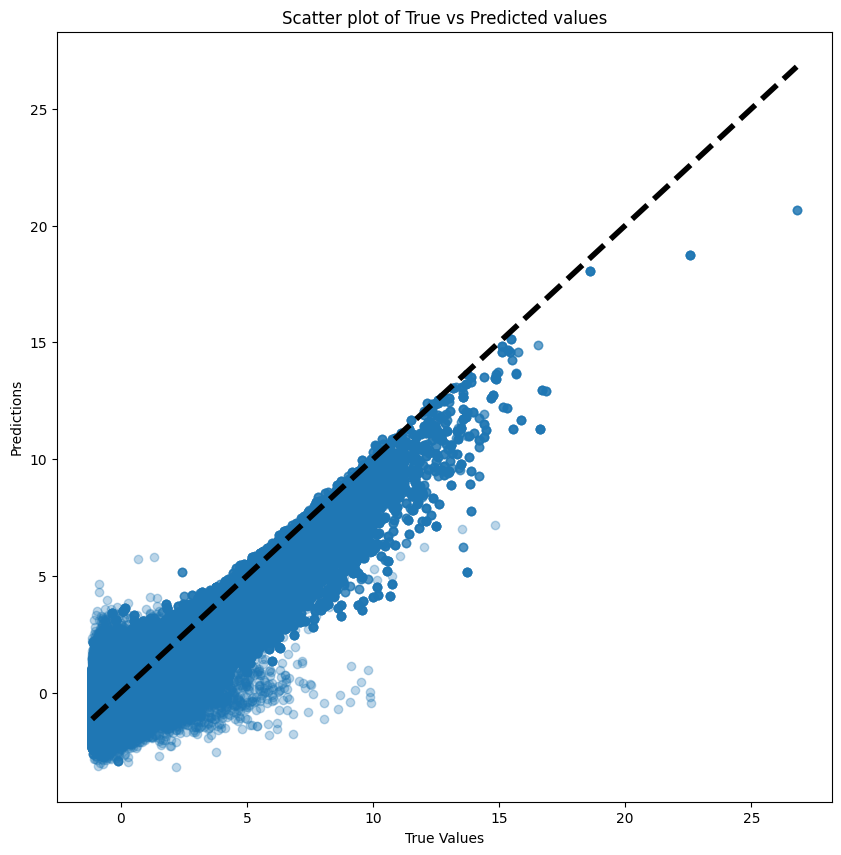

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()

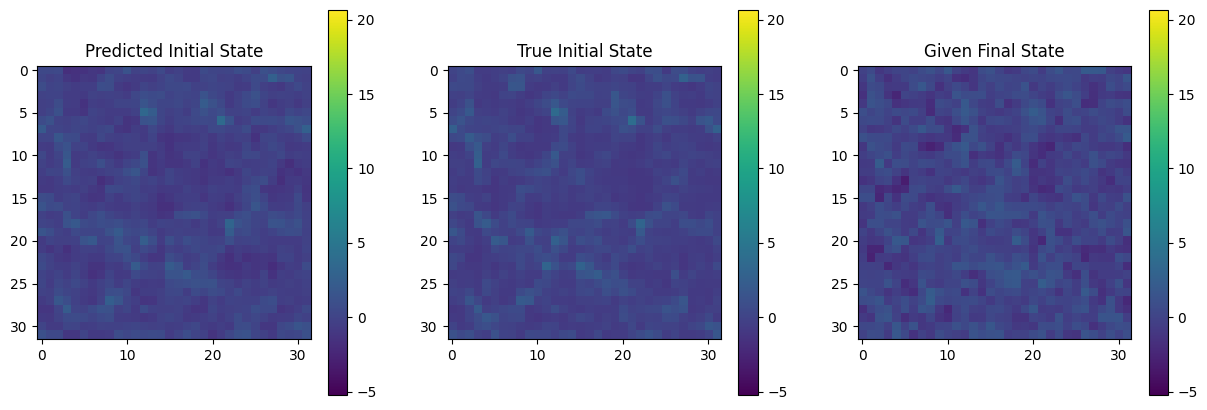

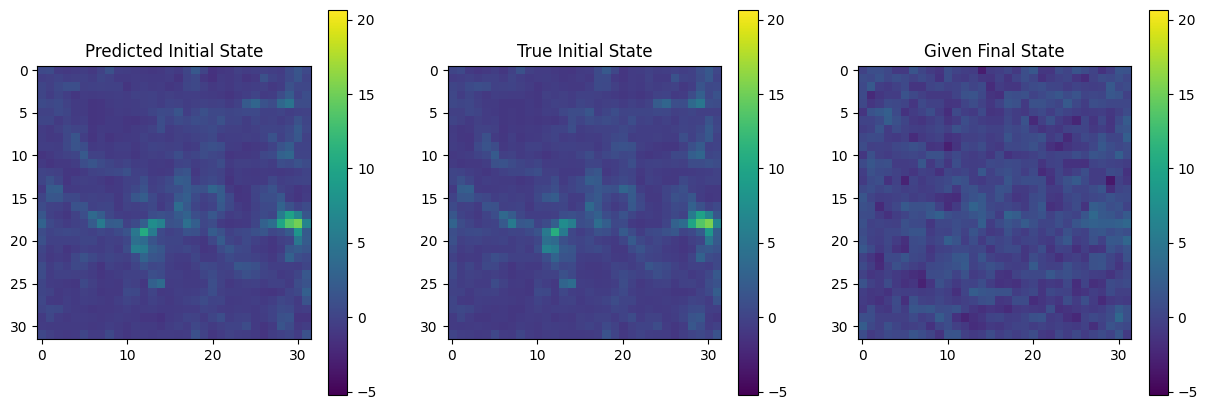

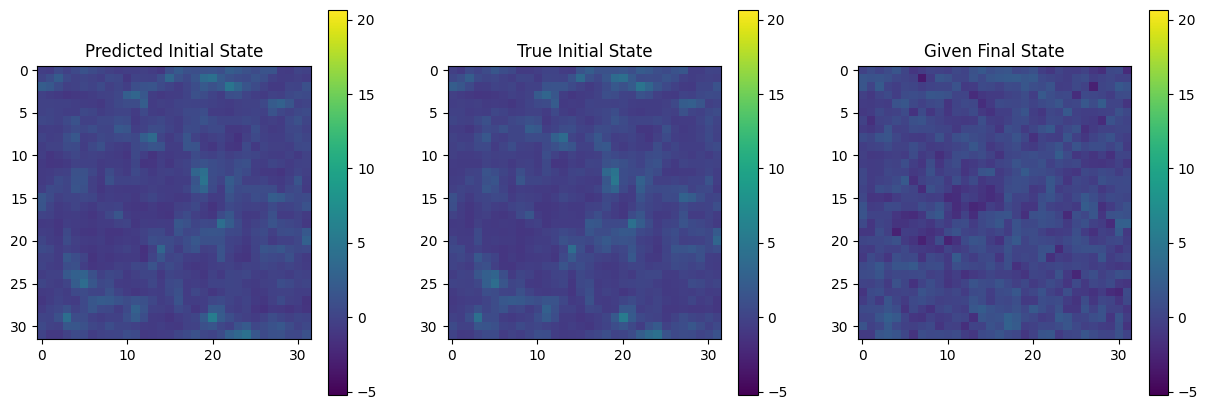

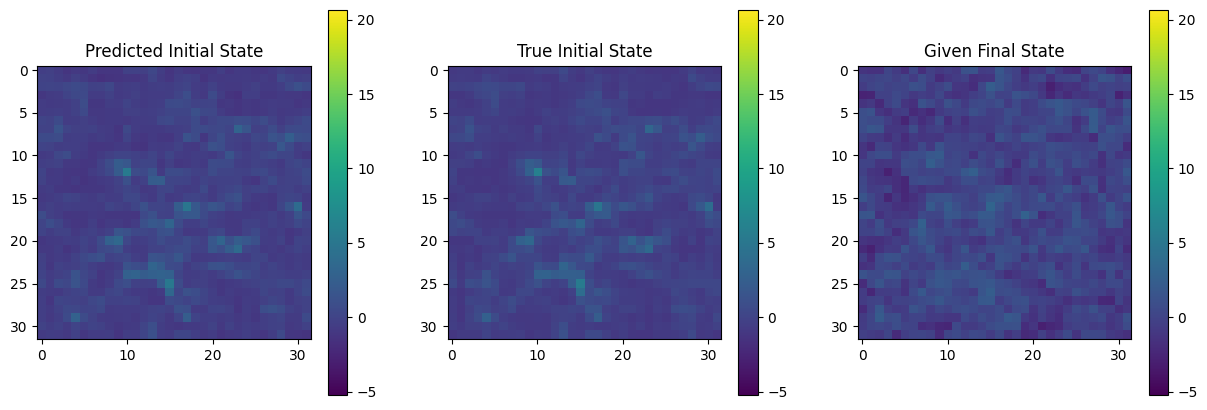

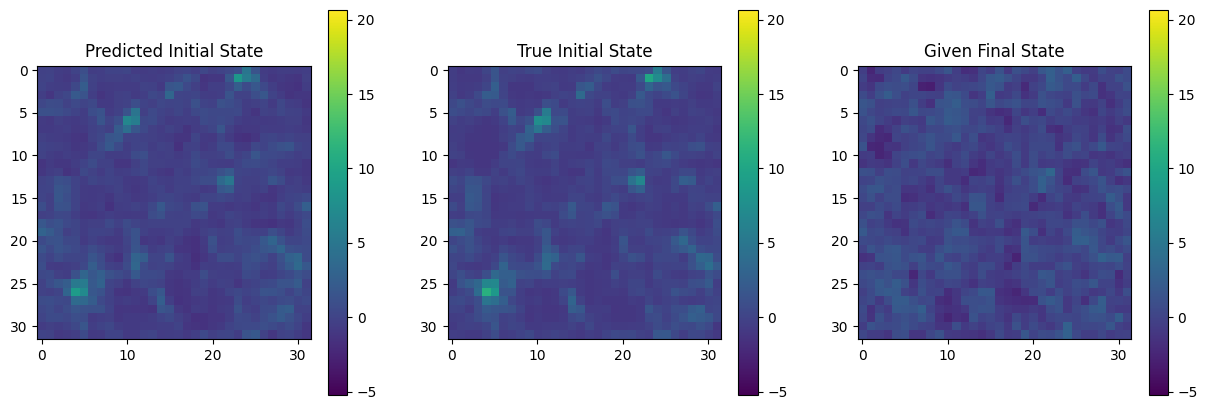

In [30]:
import random

# 5 random indices from the test data
random_indices = random.sample(range(X_test.shape[0]), 5)

for test_index in random_indices:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

1/1 [==============================] - 0s 36ms/step


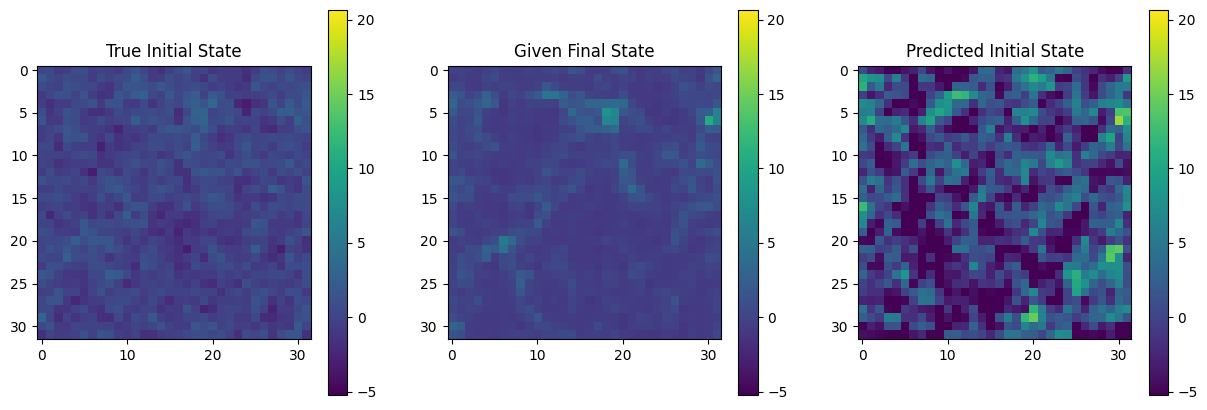

In [31]:
# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

# Reshape and expand dimensions to match the input shape of the model
input_data = np.expand_dims(final_density, axis=0)
input_data = np.expand_dims(input_data, axis=-1)

# Get the model's prediction
prediction = conv3d_model.predict(input_data)

# Plot the true initial state, the given final state and the predicted initial state
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot true initial state
im = axs[0].imshow(initial_conditions[Ngrid//2], vmin=vmin, vmax=vmax)
axs[0].set_title('True Initial State')
fig.colorbar(im, ax=axs[0])

# Plot given final state 
im = axs[1].imshow(final_density[Ngrid//2], vmin=vmin, vmax=vmax)
axs[1].set_title('Given Final State')
fig.colorbar(im, ax=axs[1])

# Plot predicted initial state
im = axs[2].imshow(prediction.reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
axs[2].set_title('Predicted Initial State')
fig.colorbar(im, ax=axs[2])

plt.show()

# script complete